In [134]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

pd.set_option('display.min_row', 25)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
streets = pd.read_csv('../data/Seattle_Streets.csv', index_col='OBJECTID')

In [136]:
streets.head(2)

,ARTCLASS,COMPKEY,UNITID,UNITID2,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,STATUS,BLOCKNBR,SPEEDLIMIT,SEGDIR,ONEWAY,ONEWAYDIR,FLOW,SEGLENGTH,SURFACEWIDTH,SURFACETYPE_1,SURFACETYPE_2,INTRLO,DIRLO,INTKEYLO,INTRHI,DIRHI,NATIONHWYSYS,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,PARKBOULEVARD,SHAPE_Length
OBJECTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.0,1006,10.0,120.0,100120.0,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,1ST AVE,SENECA ST,UNIVERSITY ST,Minor Arterial,,INSVC,1200.0,25.0,NW,N,,,306.0,48.0,PCC,AC/PCC,1ST AVE AND SENECA ST,NW,29611.0,1ST AVE AND UNIVERSITY ST,SE,N,Downtown Neighborhood,87.0,62.0,1,PRINCIPAL TRANSIT ROUTE,4.0,ART,N,305.966050
2,2.0,1009,10.0,150.0,100150.0,1ST AVE BETWEEN PIKE ST AND PINE ST,1ST AVE,PIKE ST,PINE ST,Minor Arterial,,INSVC,1500.0,25.0,NW,N,,,426.0,104.0,AC/PCC,PCC,1ST AVE AND PIKE ST,NW,29593.0,1ST AVE AND PINE ST,SE,N,Downtown Neighborhood,57.0,58.0,1,PRINCIPAL TRANSIT ROUTE,5.0,ART,N,426.031562


In [137]:
intersections = pd.read_csv('../data/Intersections.csv')

In [138]:
intersections.head(2)

,X,Y,OBJECTID,INTR_ID,GIS_XCOORD,GIS_YCOORD,COMPKEY,COMPTYPE,UNITID,SUBAREA,UNITDESC,ARTERIALCLASSCD,SIGNAL_MAINT_DIST,SIGNAL_TYPE,SHAPE_LNG,SHAPE_LAT
0,1.270709e+06,194387.955195,1,18213,1.270709e+06,194387.95532,340313,13,78852,GRDWM,4TH AVE S AND S HENDERSON N ST,0.0,,NONE,-122.329732,47.523051
1,1.282582e+06,234414.695012,2,10302,1.282582e+06,234414.69508,157936,13,32854,E,WOODROW PL E AND E GARFIELD ST,0.0,,NONE,-122.284745,47.633387


### Data Clean the Collisions Data

In [139]:
collisions = pd.read_csv('../data/feateng_collisions.csv', index_col='Datetime', low_memory=False)

collisions = (collisions.sort_index().drop(columns=['EXCEPTRSNDESC', 'EXCEPTRSNCODE', 'REPORTNO', 'STATUS']))

In [140]:
collisions.head(2)

,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,3279003.0,NaN,NaN,NaN,0,0,N,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
2004-01-01 00:00:00,-122.316863,47.615847,18457,32216,32216,Block,NaN,12TH AVE BETWEEN E PINE ST AND E OLIVE ST,1,Property Damage Only Collision,Other,5,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE",NaN,0,Raining,Dry,Dark - Street Lights On,NaN,4001022.0,NaN,23,From same direction - all others,0,0,N,"(47.6158466942628, -122.31686348709101)",0.008300,1.251186,0.073032,0.034031


### Target Column: Severity Code

In [42]:
collisions.groupby(['SEVERITYCODE', 'SEVERITYDESC']).count()

,,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
SEVERITYCODE,SEVERITYDESC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Unknown,21509,21509,21509,21509,21509,21509,21509,19733,4463,19623,12735,6073,1,21509,21509,21509,21509,21509,21509,21509,21509,15939,21508,21508,0,0,1,1,1,1,10205,0,12115,1,21509,21509,21509,21509,21509,21509,21509,21509
1,Property Damage Only Collision,136964,136964,136964,136964,136964,136964,136964,135228,37381,134556,58242,5139,133330,136964,136964,136964,136964,136964,136964,136964,136964,131021,136964,136964,19410,133338,133192,133241,133110,464,81429,5847,136959,133330,136964,136964,136964,136964,136964,136964,136964,136964
2,Injury Collision,58441,58441,58441,58441,58441,58441,58441,58250,27919,58168,27301,515,57480,58441,58441,58441,58441,58441,58441,58441,58441,58039,58441,58441,10400,57492,57435,57461,57429,4229,33507,3561,58428,57480,58441,58441,58441,58441,58441,58441,58441,58441
2b,Serious Injury Collision,3077,3077,3077,3077,3077,3077,3077,3074,1552,3069,1393,18,3037,3077,3077,3077,3077,3077,3077,3077,3077,3059,3077,3077,361,3037,3031,3036,3030,430,1869,373,3077,3037,3077,3077,3077,3077,3077,3077,3077,3077
3,Fatality Collision,346,346,346,346,346,346,346,346,156,346,263,0,338,346,346,346,346,346,346,346,346,345,346,346,16,338,338,338,338,53,195,89,346,338,346,346,346,346,346,346,346,346


In [142]:
# replace 2b with 3 and 3 with 4 in order to change column into int type
collisions['SEVERITYCODE'].replace('3', '4', inplace=True)
collisions['SEVERITYCODE'].replace('2b', '3', inplace=True)

In [143]:
collisions['SEVERITYCODE'].value_counts()

1    136964
2     58441
0     21509
3      3077
4       346
Name: SEVERITYCODE, dtype: int64

In [144]:
# Severity code only contains one nan value and given that the severity desc is Unknown, the appropriate label is 0
collisions['SEVERITYCODE'].fillna(value=0, inplace=True)

In [145]:
collisions['SEVERITYCODE'] = collisions['SEVERITYCODE'].astype(int)

In [146]:
collisions[['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES']].corr()

,SEVERITYCODE,INJURIES,SERIOUSINJURIES,FATALITIES
SEVERITYCODE,1.000000,0.700327,0.280234,0.168116
INJURIES,0.700327,1.000000,0.279734,0.067403
SERIOUSINJURIES,0.280234,0.279734,1.000000,0.173780
FATALITIES,0.168116,0.067403,0.173780,1.000000


### Fill in numbers for records showing no people involvement even when there are vehicles

In [271]:
no_people = collisions.loc[(collisions['PEDCOUNT'] == 0) & 
           (collisions['PEDCYLCOUNT'] == 0) & 
           (collisions['PERSONCOUNT'] == 0) & 
            (collisions['VEHCOUNT'] == 0)]

people = collisions.loc[(collisions['PEDCOUNT'] != 0) | 
           (collisions['PEDCYLCOUNT'] != 0) | 
           (collisions['PERSONCOUNT'] != 0) | 
            (collisions['VEHCOUNT'] != 0)]

In [272]:
# Replace the values in no_people df and merge with original collisions set
veh_count = no_people['SDOT_COLDESC'].apply(lambda x: x.count('VEHICLE') if type(x) == str else 0)
ped_count = no_people['SDOT_COLDESC'].apply(lambda x: x.count('PEDESTRIAN') if type(x) == str else 0)
cyclist_count = no_people['SDOT_COLDESC'].apply(lambda x: x.count('PEDALCYCLIST') if type(x) == str else 0)

no_people.loc[:,'VEHCOUNT'] = veh_count
no_people.loc[:,'PEDCOUNT'] = ped_count
no_people.loc[:, 'PEDCYLCOUNT'] = cyclist_count

/Users/cindywong/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [316]:
# Merge the people and no_people dataframes
df = pd.concat([no_people, people])

In [317]:
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,3279003.0,NaN,NaN,NaN,0,0,N,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
2004-01-01 00:00:00,-122.313520,47.601688,9296,22796,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,NaN,NaN,NaN,NaN,NaN,4001029.0,NaN,NaN,NaN,0,0,N,"(47.6016875604153, -122.31351964524299)",0.085651,1.502844,0.074822,0.023317
2004-01-01 00:00:00,-122.337454,47.615057,13901,27177,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4001027.0,NaN,NaN,NaN,0,0,N,"(47.615056751488396, -122.337454236738)",0.009403,0.999276,0.513238,0.005482
2004-01-01 00:00:00,0.000000,0.000000,14794,29248,29248,NaN,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/01 00:00:00+00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,4001030.0,NaN,NaN,NaN,0,0,N,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
2004-01-01 00:00:00,-122.360959,47.571594,13167,25538,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF RP AND HARBOR AV SW OFF RP,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,NaN,NaN,NaN,NaN,NaN,4001028.0,NaN,NaN,NaN,0,0,N,"(47.5715936116426, -122.360958600635)",0.115034,0.485087,0.635936,0.034460


### Binary Columns

In [318]:
# encode binary columns
binary_cols = ['SPEEDING', 'INATTENTIONIND', 'HITPARKEDCAR', 'PEDROWNOTGRNT']

for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'Y' else 0)

In [319]:
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,3279003.0,0,NaN,NaN,0,0,0,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
2004-01-01 00:00:00,-122.313520,47.601688,9296,22796,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,NaN,NaN,NaN,NaN,0,4001029.0,0,NaN,NaN,0,0,0,"(47.6016875604153, -122.31351964524299)",0.085651,1.502844,0.074822,0.023317
2004-01-01 00:00:00,-122.337454,47.615057,13901,27177,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",0,NaN,NaN,NaN,NaN,0,4001027.0,0,NaN,NaN,0,0,0,"(47.615056751488396, -122.337454236738)",0.009403,0.999276,0.513238,0.005482
2004-01-01 00:00:00,0.000000,0.000000,14794,29248,29248,NaN,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/01 00:00:00+00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,0,NaN,NaN,NaN,NaN,0,4001030.0,0,NaN,NaN,0,0,0,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
2004-01-01 00:00:00,-122.360959,47.571594,13167,25538,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF RP AND HARBOR AV SW OFF RP,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,NaN,NaN,NaN,NaN,0,4001028.0,0,NaN,NaN,0,0,0,"(47.5715936116426, -122.360958600635)",0.115034,0.485087,0.635936,0.034460


### Under Influence Column

In [322]:
# presumably, it is either a yes or no. 
# NaN values is likely to be 0/N but it could also be that it was unclear at the time. Will change this to categorical instead
# map the rest of the values first and label NaN values as the 0 category

print(df['UNDERINFL'].value_counts(dropna=False))
df['UNDERINFL'] = df['UNDERINFL'].map({'Y':2, '1':2, 'N':1, '0':1})

N      102902
0       81676
NaN     26132
Y        5398
1        4230
Name: UNDERINFL, dtype: int64


In [323]:
df['UNDERINFL'].fillna(0, inplace=True)
df['UNDERINFL'] = df['UNDERINFL'].astype(int)
df['UNDERINFL'].value_counts(dropna=False)

1    184578
0     26132
2      9628
Name: UNDERINFL, dtype: int64

### Condition Columns

In [174]:
cond_cols = ['WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEVERITYCODE']

for x in cond_cols:
    print(x, ':', '\n', df[x].value_counts())
    print('\n')

WEATHER : 
 Clear                       113939
Raining                      33961
Overcast                     28417
Unknown                      15131
Snowing                        919
Other                          849
Fog/Smog/Smoke                 576
Sleet/Hail/Freezing Rain       116
Blowing Sand/Dirt               56
Severe Crosswind                26
Partly Cloudy                    8
Name: WEATHER, dtype: int64


ROADCOND : 
 Dry               127675
Wet                48635
Unknown            15127
Ice                 1231
Snow/Slush          1014
Other                136
Standing Water       119
Sand/Mud/Dirt         77
Oil                   64
Name: ROADCOND, dtype: int64


LIGHTCOND : 
 Daylight                    118721
Dark - Street Lights On      49963
Unknown                      13515
Dusk                          6060
Dawn                          2583
Dark - No Street Lights       1571
Dark - Street Lights Off      1235
Other                          244
Dark - Unk

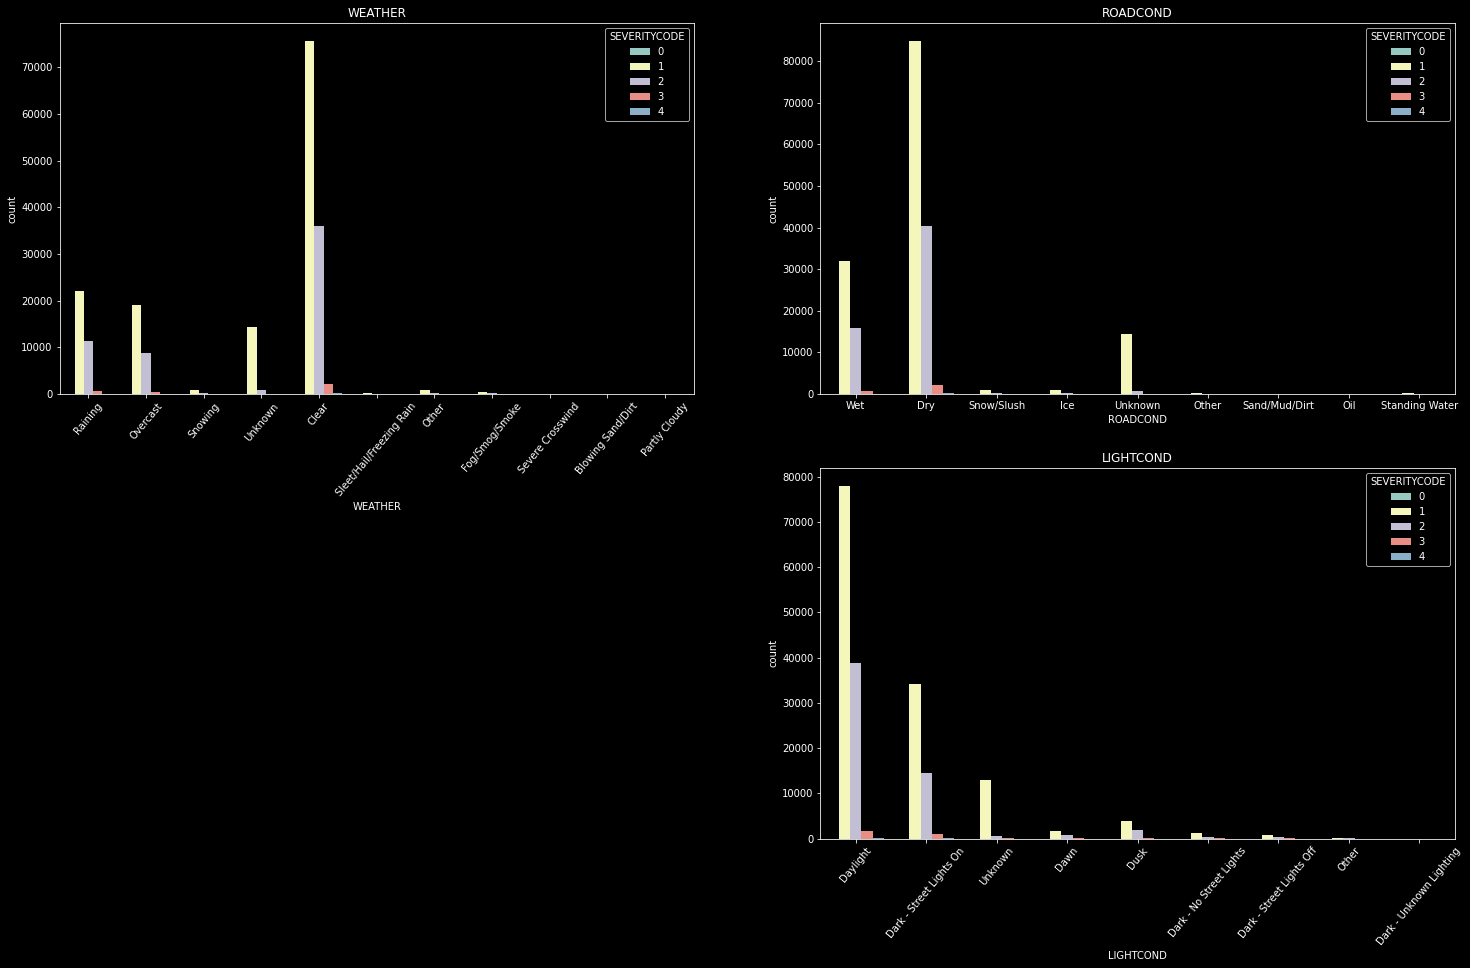

In [255]:
fig, axes = plt.subplots(2,2,figsize=(25,15))

ax1 = sns.countplot('WEATHER', hue='SEVERITYCODE', data=df, ax=axes[0][0])
axes[0][0].legend(title='SEVERITYCODE', loc='upper right')
axes[0][0].set_xticklabels(ax1.get_xticklabels(), rotation=50)
ax1.set_title('WEATHER');

ax2 = sns.countplot('ROADCOND', hue='SEVERITYCODE', data=df, ax=axes[0][1])
axes[0][1].legend(title='SEVERITYCODE', loc='upper right')
ax2.set_title('ROADCOND');

ax3 = sns.countplot('LIGHTCOND', hue='SEVERITYCODE', data=df, ax = axes[1][1])
axes[1][1].legend(title='SEVERITYCODE', loc='upper right')
axes[1][1].set_xticklabels(ax3.get_xticklabels(), rotation=50)
ax3.set_title('LIGHTCOND');


fig.delaxes(axes[1][0])
fig.tight_layout;

In [256]:
def encode_weather(x):
    '''
    One hot encodes the WEATHER column.
    
    Input: Pd.Series, WEATHER column
    Returns: OHE WEATHER column
    '''
    if (x == 'Unknown') or (x == 'Other') or (x == 0):
        return 0
    elif (x == 'Clear'):
        return 1
    else:
        return 2    

def encode_road(x):
    '''
    One hot encodes the ROADCOND column.
    
    Input: Pd.Series, ROADCOND column
    Returns: OHE ROADCOND column
    '''
    if (x == 'Unknown') or (x == 'Other') or (x == 0):
        return 0
    elif x == 'Dry':
        return 1
    else:
        return 2
    
def encode_light(x):
    '''
    One hot encodes the LIGHTCOND column. Choice of 'Dark- Unknown lighting' with the other dark conditions
    
    Input: Pd.Series, LIGHTCOND column
    Returns: OHE LIGHTCOND column
    '''
    
    if (x == 'Unknown') or (x == 'Other') or (x == 0):
        return 0
    elif x == 'Daylight':
        return 1
    elif (x == 'Dawn') or (x == 'Dusk') or (x == 'Dark - Street Lights On'):
        return 2
    else:
        return 3

In [257]:
# Encode weather, road, and light conditions. Nan is filled with 0 prior to OHE

for series, function in zip(['WEATHER', 'ROADCOND', 'LIGHTCOND'], 
                            [encode_weather, encode_road, encode_light]):
    df[series] = df[series].fillna(0).apply(function)
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,0,0,0,0,0,1,3279003.0,0,NaN,NaN,0,0,0,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
2004-01-01 00:00:00,-122.313520,47.601688,9296,22796,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,0,0,0,0,0,4001029.0,0,NaN,NaN,0,0,0,"(47.6016875604153, -122.31351964524299)",0.085651,1.502844,0.074822,0.023317
2004-01-01 00:00:00,-122.337454,47.615057,13901,27177,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",0,0,0,0,0,0,4001027.0,0,NaN,NaN,0,0,0,"(47.615056751488396, -122.337454236738)",0.009403,0.999276,0.513238,0.005482
2004-01-01 00:00:00,0.000000,0.000000,14794,29248,29248,NaN,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/01 00:00:00+00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,0,0,0,0,0,0,4001030.0,0,NaN,NaN,0,0,0,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
2004-01-01 00:00:00,-122.360959,47.571594,13167,25538,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF RP AND HARBOR AV SW OFF RP,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,0,0,0,0,0,4001028.0,0,NaN,NaN,0,0,0,"(47.5715936116426, -122.360958600635)",0.115034,0.485087,0.635936,0.034460


In [267]:
# columns with null values
df.columns[df.isnull().sum() > 0]

Index(['ADDRTYPE', 'INTKEY', 'LOCATION', 'COLLISIONTYPE', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLCODE',
       'ST_COLDESC'],
      dtype='object')

Future predictions will be given only information about the intersection, so choose columns that would have information without an accident happening